# import libraries

In [1]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Read Dataset

In [2]:
def read_file(*args,file_type="csv")->pd.DataFrame:
    """:parameter input directories in sequence
        :return DataFrame"""
    
    path=os.path.join(*args)
    if file_type == "tsv":
        return pd.read_csv(path, sep="\t")
    return pd.read_csv(path)
    

In [3]:
df=read_file("..","data","processed","cleaned.csv")

In [4]:
df.duplicated().sum()

637

In [5]:
df.isnull().sum()

comment     0
category    0
dtype: int64

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
X=df.comment
y=df.category

# split Dataset

In [13]:
X_train,X_temp,y_train,y_temp=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [14]:
X_val,X_test,y_val,y_test=train_test_split(X_temp,y_temp,test_size=0.5,random_state=42,stratify=y_temp)

In [15]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,y_test.shape

((28992,), (28992,), (3624,), (3624,), (3624,))

# save dataset

In [16]:
pd.concat([X_train,y_train],axis=1).to_csv(os.path.join("..","data","processed","train.csv"),index=False)

In [17]:
pd.concat([X_val,y_val],axis=1).to_csv(os.path.join("..","data","processed","val.csv"),index=False)

In [18]:
pd.concat([X_test,y_test],axis=1).to_csv(os.path.join("..","data","processed","test.csv"),index=False)

# Feature Engineering

In [141]:
count2vec1=CountVectorizer(ngram_range=(1,1),max_features=5000,stop_words=None)

In [142]:
count2vec1.fit(X)


CountVectorizer(max_features=5000)

In [143]:
X_train=count2vec1.transform(X_train).toarray()
X_val=count2vec1.transform(X_val).toarray()
X_test=count2vec1.transform(X_test).toarray()

# Base model train

In [144]:
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestClassifier

In [147]:
mlflow.set_tracking_uri("http://54.164.94.210:5000")

In [148]:
mlflow.set_experiment("RF_Base")

2024/10/14 04:00:15 INFO mlflow.tracking.fluent: Experiment with name 'RF_Base' does not exist. Creating a new experiment.


<Experiment: artifact_location='s3://mlflowbucketsentiment/383100008867990830', creation_time=1728858616273, experiment_id='383100008867990830', last_update_time=1728858616273, lifecycle_stage='active', name='RF_Base', tags={}>

2024/10/14 04:01:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024/10/14 04:01:09 INFO mlflow.tracking._tracking_service.client: 🏃 View run RandomForest at: http://54.164.94.210:5000/#/experiments/383100008867990830/runs/d989b4c3cdc74485ad2b7ef6edaf4b04.
2024/10/14 04:01:09 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://54.164.94.210:5000/#/experiments/383100008867990830.


Accuracy: 0.6575379609544468


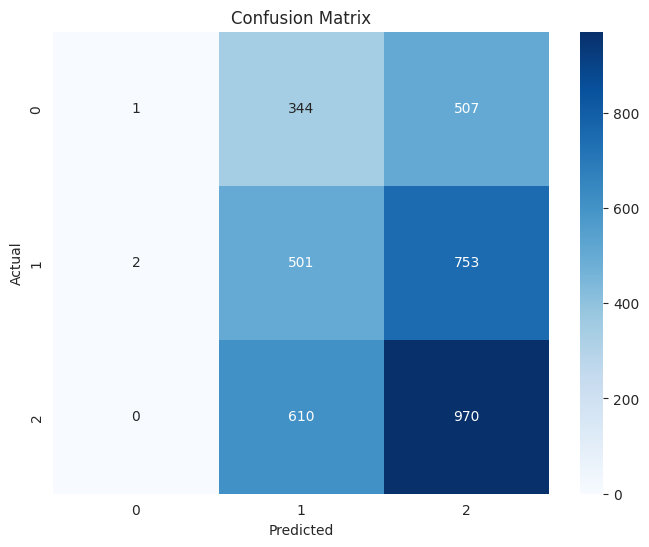

In [149]:
with mlflow.start_run() as run:
    # Log a description for the run
    mlflow.set_tag("mlflow.runName", "RandomForest")
    mlflow.set_tag("experiment_type","baseline")
    mlflow.set_tag("model_type","RandomForestClassifier")
    
    # Add a description
    mlflow.set_tag("description","Baseline RandomForestClassifier model for sentiment analysis")
    
    # Log parameters for the vectorizer
    mlflow.log_param("vectorizer_type","CountVectorizer")
    mlflow.log_param("max_features",count2vec1.max_features)
    
    # Log Random Forest Parameters
    n_estimators=200
    max_depth=10
    
    mlflow.log_param("n_estimators",n_estimators)
    mlflow.log_param("max_depth",max_depth)
    
    #Initialize and train the model 
    model = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth)
    model.fit(X_train,y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_val)
    
    # Log metrics for each class and accuracy
    accuracy = accuracy_score(y_val,y_pred)
    mlflow.log_metric("accuracy",accuracy)
    
    classification_report = classification_report(y_val,y_pred,output_dict=True)
    
    for label, metrics in classification_report.items():
        if isinstance(metrics, dict):  # For precision, recall, f1-score, etc.
            for metric, value in metrics.items():
                mlflow.log_metric(f"{label}_{metric}", value)
    
    # Confusion matrix plot
    conf_matrix = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")

    # Save and log the confusion matrix plot
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")

    # Log the Random Forest model
    mlflow.sklearn.log_model(model, "random_forest_model")
    

# Display final accuracy
print(f"Accuracy: {accuracy}")

In [ ]:
print()